In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn

from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs
import singletask_dep as st

import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

encoding_type = 'pos'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
vocab_dep = st.Vocabulary(data['train'],encoding_type)
convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_train,['about','to','as'],vocab_dep,word_to_index) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn(convai_val,['about','to','as'],vocab_dep,word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,deps=True)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,deps=True)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn(md_data,['about','to','as'],vocab_dep,word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,deps=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# Prueba hiperparámetros 1

In [14]:
emb_dim = 20
vocab_size = len(word_to_index)
lstm_hidden_dim = 128

## ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6972667227015678 	 Validation loss: 0.6921581898705434 	 
  1%|          | 574/57400 [00:06<09:16, 102.08it/s]
Epoch 2 	 Training loss: 0.6886579413031867 	 Validation loss: 0.6867787625830052 	 
  2%|▏         | 1148/57400 [00:12<09:14, 101.53it/s]
Epoch 3 	 Training loss: 0.6839961435528997 	 Validation loss: 0.6842370407056 	 
  3%|▎         | 1722/57400 [00:18<09:10, 101.08it/s]
Epoch 4 	 Training loss: 0.6818987325301153 	 Validation loss: 0.6836283863601038 	 
  4%|▍         | 2296/57400 [00:25<09:03, 101.45it/s]
Epoch 5 	 Training loss: 0.6811612096813082 	 Validation loss: 0.6834115608263824 	 
  5%|▌         | 2870/57400 [00:31<09:07, 99.67it/s]
Epoch 6 	 Training loss: 0.6808943175272659 	 Validation loss: 0.6832759966284542 	 
  6%|▌         | 3444/57400 [00:37<08:56, 100.60it/s]
Epoch 7 	 Training loss: 0.6808600681168693 	 Validation loss: 0.6833013498176963 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:43<08:53, 100.06it/s]
Epo

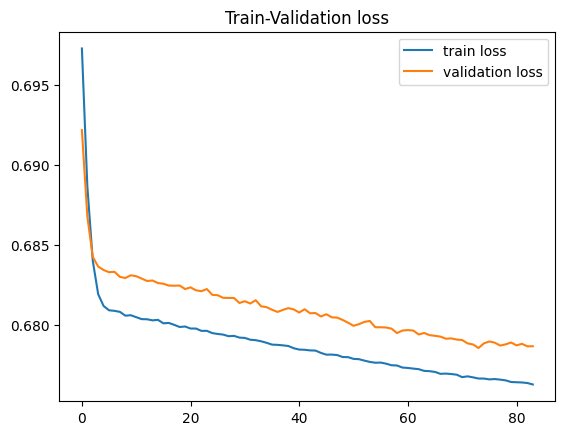

In [16]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5189393939393939, 'precision': 0.5189393939393939, 'f1': 0.5189393939393939, 'accuracy': 0.5189393939393939}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5149934810951761, 'precision': 0.5149934810951761, 'f1': 0.5149934810951761, 'accuracy': 0.5149934810951761}
MALE {'recall': 0.9974747474747475, 'precision': 0.9974747474747475, 'f1': 0.9974747474747475, 'accuracy': 0.9974747474747475}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6865454830151402 	 Validation loss: 0.6850180999707367 	 
  1%|          | 574/57400 [00:06<09:46, 96.92it/s]
Epoch 2 	 Training loss: 0.682487980621617 	 Validation loss: 0.6836678011942718 	 
  2%|▏         | 1148/57400 [00:12<09:13, 101.69it/s]
Epoch 3 	 Training loss: 0.6813121013317374 	 Validation loss: 0.6835065231484881 	 
  3%|▎         | 1722/57400 [00:18<09:01, 102.83it/s]
Epoch 4 	 Training loss: 0.6809803479016866 	 Validation loss: 0.6832096445358405 	 
  4%|▍         | 2296/57400 [00:24<08:58, 102.26it/s]
Epoch 5 	 Training loss: 0.6808870291460681 	 Validation loss: 0.6832803730237282 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:30<08:57, 101.47it/s]
Epoch 6 	 Training loss: 0.6807851341750979 	 Validation loss: 0.6830845818681232 	 
  6%|▌         | 3444/57400 [00:36<08:59, 100.09it/s]
Epoch 7 	 Training loss: 0.6805174142018428 	 Validation loss: 0.6832344491603011 	 

1 epoch without improvement
  7%|▋         | 4018/5740

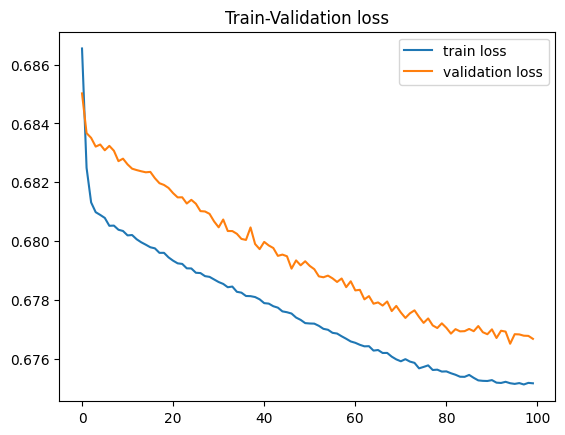

In [18]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 0.9973958333333334, 'precision': 0.9973958333333334, 'f1': 0.9973958333333334, 'accuracy': 0.9973958333333334}
FEMALE {'recall': 0.0025, 'precision': 0.0025, 'f1': 0.0025, 'accuracy': 0.0025} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0026246719160104987, 'precision': 0.0026246719160104987, 'f1': 0.0026246719160104987, 'accuracy': 0.0026246719160104987} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
F

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6885190593656347 	 Validation loss: 0.6869057184558803 	 
  1%|          | 574/57400 [00:06<09:40, 97.86it/s]
Epoch 2 	 Training loss: 0.6841685850861181 	 Validation loss: 0.6846880488476511 	 
  2%|▏         | 1148/57400 [00:12<09:19, 100.57it/s]
Epoch 3 	 Training loss: 0.6821990616437865 	 Validation loss: 0.6837838484069049 	 
  3%|▎         | 1722/57400 [00:18<09:19, 99.59it/s]
Epoch 4 	 Training loss: 0.6813863947831795 	 Validation loss: 0.6836484610024145 	 
  4%|▍         | 2296/57400 [00:24<09:02, 101.58it/s]
Epoch 5 	 Training loss: 0.681162895225897 	 Validation loss: 0.6834533376208807 	 
  5%|▌         | 2870/57400 [00:30<09:05, 99.93it/s]
Epoch 6 	 Training loss: 0.6809925104682869 	 Validation loss: 0.6838202759370966 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:36<08:56, 100.63it/s]
Epoch 7 	 Training loss: 0.6808638876946546 	 Validation loss: 0.6835653003999742 	 

2 epoch without improvement
  7%|▋         | 4018/57400 

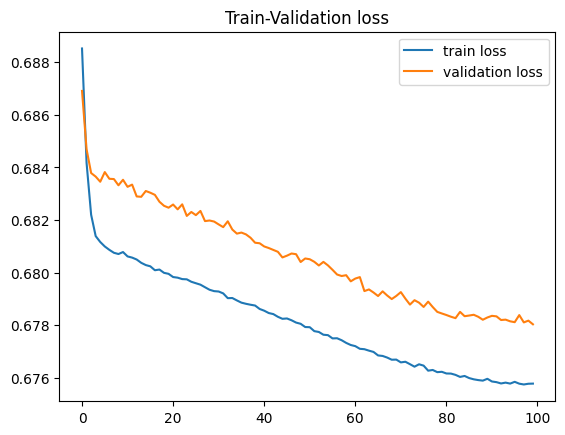

In [20]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_about_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [21]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0026246719160104987, 'precision': 0.0026246719160104987, 'f1': 0.0026246719160104987, 'accuracy': 0.0026246719160104987} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.516297262059974, 'precision': 0.516297262059974, 'f1': 0.516297262059974, 'accuracy': 0.516297262059974}
MALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
FEMALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0} 



In [22]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.4897959183673469, 'precision': 0.4897959183673469, 'f1': 0.4897959183673469, 'accuracy': 0.4897959183673469}
Métricas etiqueta male: {'recall': 0.9991319444444444, 'precision': 0.9991319444444444, 'f1': 0.9991319444444444, 'accuracy': 0.9991319444444444}
Métricas etiqueta female:  {'recall': 0.0008333333333333334, 'precision': 0.0008333333333333334, 'f1': 0.0008333333333333334, 'accuracy': 0.0008333333333333334}

 to
Resultado global: {'recall': 0.5197811447811448, 'precision': 0.5197811447811448, 'f1': 0.5197811447811448, 'accuracy': 0.5197811447811448}
Métricas etiqueta male: {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0}
Métricas etiqueta female:  {'recall': 0.0017497812773403325, 'precision': 0.0017497812773403325, 'f1': 0.0017497812773403325, 'accuracy': 0.0017497812773403325}

 as
Resultado global: {'recall': 0.5158626684050414, 'precision': 0.5158626684050414, 'f1': 0.5158626684050414, 'accuracy': 0.51586

## TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931936207133303 	 Validation loss: 0.6926151948460078 	 
  1%|          | 574/57400 [00:06<10:16, 92.23it/s]
Epoch 2 	 Training loss: 0.693140684312229 	 Validation loss: 0.692644416275671 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:22, 90.31it/s]
Epoch 3 	 Training loss: 0.693170574587812 	 Validation loss: 0.6929890856904498 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:20<10:16, 90.27it/s]
Epoch 4 	 Training loss: 0.693129890991005 	 Validation loss: 0.692899082676839 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:27<10:04, 91.20it/s]
Epoch 5 	 Training loss: 0.6930761378816611 	 Validation loss: 0.6928090847144692 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:33<10:04, 90.16it/s]
Epoch 6 	 Training loss: 0.6931560484997487 	 Validation loss: 0.6929366861359548 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:40<09:51, 91.29it/s]
Epoch 7 	 Training loss: 0.693115

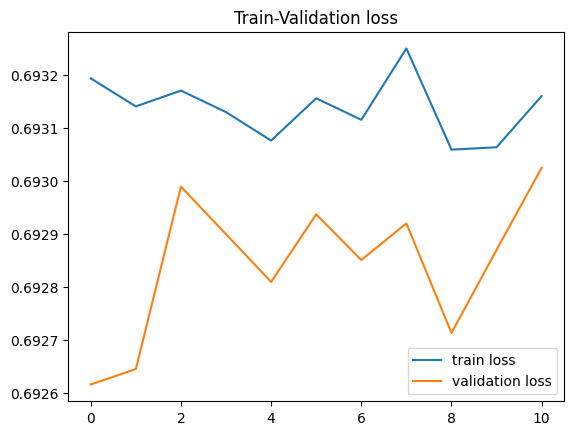

In [24]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [25]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.044270833333333336, 'precision': 0.044270833333333336, 'f1': 0.044270833333333336, 'accuracy': 0.044270833333333336}
FEMALE {'recall': 0.9375, 'precision': 0.9375, 'f1': 0.9375, 'accuracy': 0.9375} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4823232323232323, 'precision': 0.4823232323232323, 'f1': 0.4823232323232323, 'accuracy': 0.4823232323232323}
MALE {'recall': 0.0364963503649635, 'precision': 0.0364963503649635, 'f1': 0.0364963503649635, 'accuracy': 0.0364963503649635}
FEMALE {'recall': 0.963254593175853, 'precision': 0.963254593175853, 'f1': 0.963254593175853, 'accuracy': 0.963254593175853} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4810951760104302, 'precision': 0.4810951760104302, 'f1': 0.4810951760104302, 'accuracy': 0.4810951760104302}
MALE {'recall': 0.03787878787878788, 'precision': 0.03787878787878788, '

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6933435987720091 	 Validation loss: 0.6926283614110138 	 
  1%|          | 574/57400 [00:06<10:16, 92.14it/s]
Epoch 2 	 Training loss: 0.6932661818918036 	 Validation loss: 0.692995375495846 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:11, 91.95it/s]
Epoch 3 	 Training loss: 0.6932427904954771 	 Validation loss: 0.6928806335239087 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:20<09:56, 93.33it/s]
Epoch 4 	 Training loss: 0.6931902158758781 	 Validation loss: 0.6927834324917551 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:26<09:56, 92.45it/s]
Epoch 5 	 Training loss: 0.6932316528380125 	 Validation loss: 0.6931132704524671 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:33<10:03, 90.31it/s]
Epoch 6 	 Training loss: 0.6931920877109421 	 Validation loss: 0.6929481837709072 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:40<09:41, 92.71it/s]
Epoch 7 	 Training loss: 0.69

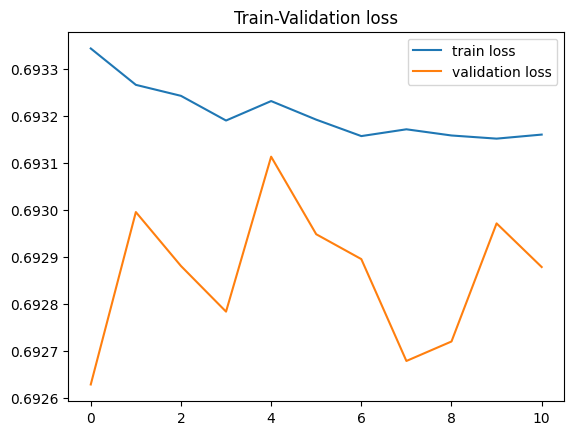

In [26]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [27]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4961734693877551, 'precision': 0.4961734693877551, 'f1': 0.4961734693877551, 'accuracy': 0.4961734693877551}
MALE {'recall': 0.0859375, 'precision': 0.0859375, 'f1': 0.0859375, 'accuracy': 0.0859375}
FEMALE {'recall': 0.89, 'precision': 0.89, 'f1': 0.89, 'accuracy': 0.89} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4684343434343434, 'precision': 0.4684343434343434, 'f1': 0.4684343434343434, 'accuracy': 0.4684343434343434}
MALE {'recall': 0.10218978102189781, 'precision': 0.10218978102189781, 'f1': 0.10218978102189782, 'accuracy': 0.10218978102189781}
FEMALE {'recall': 0.863517060367454, 'precision': 0.863517060367454, 'f1': 0.863517060367454, 'accuracy': 0.863517060367454} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4771838331160365, 'precision': 0.4771838331160365, 'f1': 0.4771838331160365, 'accuracy': 0.4771838331160365}
MALE {'recall': 0.11868686868686869, 'precision': 0.11868686

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.693176155306321 	 Validation loss: 0.6928586171845258 	 
  1%|          | 574/57400 [00:06<10:42, 88.45it/s]
Epoch 2 	 Training loss: 0.6931655344647397 	 Validation loss: 0.6929323562120987 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:26, 89.81it/s]
Epoch 3 	 Training loss: 0.6931885028134656 	 Validation loss: 0.6928927120515855 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:20<10:25, 88.98it/s]
Epoch 4 	 Training loss: 0.693177198076082 	 Validation loss: 0.6927848902799315 	 
  4%|▍         | 2296/57400 [00:26<09:58, 92.02it/s]
Epoch 5 	 Training loss: 0.6931723927371594 	 Validation loss: 0.6929601137920961 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:33<10:02, 90.44it/s]
Epoch 6 	 Training loss: 0.6930925863752797 	 Validation loss: 0.692901144593449 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [00:40<09:56, 90.46it/s]
Epoch 7 	 Training loss: 0.6932231701832615 	 Validation los

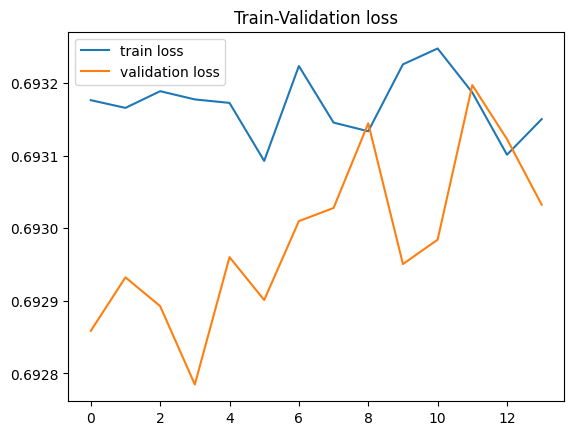

In [28]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_to_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [29]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.4987244897959184, 'precision': 0.4987244897959184, 'f1': 0.4987244897959184, 'accuracy': 0.4987244897959184}
MALE {'recall': 0.20833333333333334, 'precision': 0.20833333333333334, 'f1': 0.20833333333333334, 'accuracy': 0.20833333333333334}
FEMALE {'recall': 0.7775, 'precision': 0.7775, 'f1': 0.7775, 'accuracy': 0.7775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
MALE {'recall': 0.19464720194647203, 'precision': 0.19464720194647203, 'f1': 0.19464720194647203, 'accuracy': 0.19464720194647203}
FEMALE {'recall': 0.8083989501312336, 'precision': 0.8083989501312336, 'f1': 0.8083989501312336, 'accuracy': 0.8083989501312336} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.485006518904824, 'precision': 0.485006518904824, 'f1': 0.485006518904824, 'accuracy': 0.485006518904824}
MALE {'recal

In [30]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.49829931972789115, 'precision': 0.49829931972789115, 'f1': 0.49829931972789115, 'accuracy': 0.49829931972789115}
Métricas etiqueta male: {'recall': 0.11284722222222222, 'precision': 0.11284722222222222, 'f1': 0.11284722222222222, 'accuracy': 0.11284722222222222}
Métricas etiqueta female:  {'recall': 0.8683333333333333, 'precision': 0.8683333333333333, 'f1': 0.8683333333333333, 'accuracy': 0.8683333333333333}

 to
Resultado global: {'recall': 0.4802188552188552, 'precision': 0.4802188552188552, 'f1': 0.4802188552188552, 'accuracy': 0.4802188552188552}
Métricas etiqueta male: {'recall': 0.11111111111111112, 'precision': 0.11111111111111112, 'f1': 0.11111111111111112, 'accuracy': 0.11111111111111112}
Métricas etiqueta female:  {'recall': 0.8783902012248469, 'precision': 0.8783902012248469, 'f1': 0.8783902012248469, 'accuracy': 0.8783902012248469}

 as
Resultado global: {'recall': 0.4810951760104302, 'precision': 0.481095176010430

# AS

In [31]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6941196368131073 	 Validation loss: 0.6921915684716177 	 
  1%|          | 574/57400 [00:06<10:20, 91.55it/s]
Epoch 2 	 Training loss: 0.6933660201910066 	 Validation loss: 0.6925421397564775 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:15, 91.41it/s]
Epoch 3 	 Training loss: 0.6931852155238494 	 Validation loss: 0.6926547369714511 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:20<10:04, 92.03it/s]
Epoch 4 	 Training loss: 0.6932587876967852 	 Validation loss: 0.6928741275253942 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:27<10:02, 91.47it/s]
Epoch 5 	 Training loss: 0.6932111733466491 	 Validation loss: 0.6926279785269398 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:33<09:54, 91.78it/s]
Epoch 6 	 Training loss: 0.6932427023346001 	 Validation loss: 0.6928954700292167 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:40<09:44, 92.29it/s]
Epoch 7 	 Training loss: 0.6

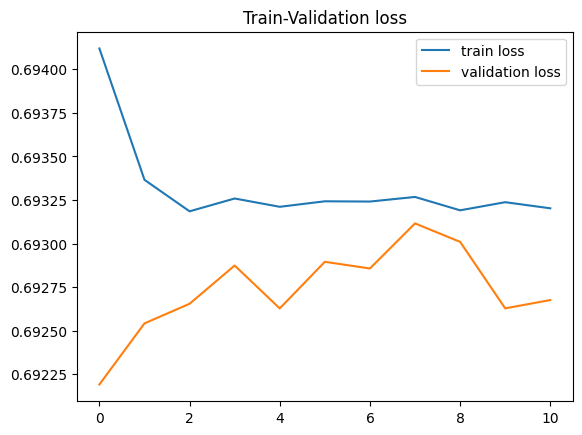

In [32]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_1'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [33]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5280612244897959, 'precision': 0.5280612244897959, 'f1': 0.5280612244897959, 'accuracy': 0.5280612244897959}
MALE {'recall': 0.078125, 'precision': 0.078125, 'f1': 0.078125, 'accuracy': 0.078125}
FEMALE {'recall': 0.96, 'precision': 0.96, 'f1': 0.96, 'accuracy': 0.96} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
MALE {'recall': 0.05596107055961071, 'precision': 0.05596107055961071, 'f1': 0.05596107055961071, 'accuracy': 0.05596107055961071}
FEMALE {'recall': 0.958005249343832, 'precision': 0.958005249343832, 'f1': 0.958005249343832, 'accuracy': 0.958005249343832} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4876140808344198, 'precision': 0.4876140808344198, 'f1': 0.4876140808344198, 'accuracy': 0.4876140808344198}
MALE {'recall': 0.045454545454545456, 'precision': 0.04545454545

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6932069911566345 	 Validation loss: 0.6931294253316976 	 
  1%|          | 574/57400 [00:06<10:21, 91.46it/s]
Epoch 2 	 Training loss: 0.6931578100558358 	 Validation loss: 0.6929857468200942 	 
  2%|▏         | 1148/57400 [00:13<10:10, 92.21it/s]
Epoch 3 	 Training loss: 0.6930856594640619 	 Validation loss: 0.692937583236371 	 
  3%|▎         | 1722/57400 [00:20<10:03, 92.29it/s]
Epoch 4 	 Training loss: 0.6931228368747525 	 Validation loss: 0.6930503612857754 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:27<09:56, 92.38it/s]
Epoch 5 	 Training loss: 0.6931352109651532 	 Validation loss: 0.6930089805085781 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:33<09:54, 91.66it/s]
Epoch 6 	 Training loss: 0.6931101452390491 	 Validation loss: 0.6931174993515015 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [00:40<09:56, 90.52it/s]
Epoch 7 	 Training loss: 0.6931516934147279 	 Validation loss: 0.6928550540390661 	 
  

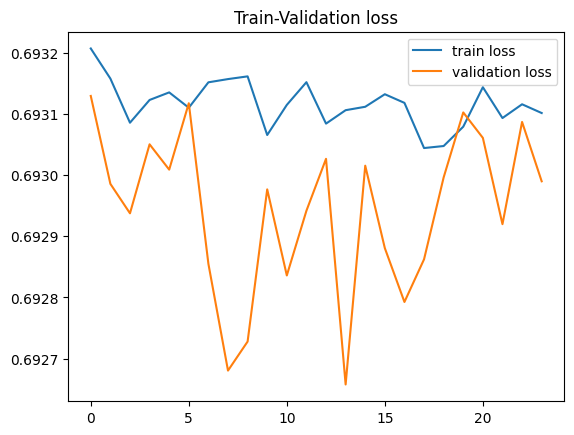

In [34]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_2'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.47066326530612246, 'precision': 0.47066326530612246, 'f1': 0.47066326530612246, 'accuracy': 0.47066326530612246}
MALE {'recall': 0.6640625, 'precision': 0.6640625, 'f1': 0.6640625, 'accuracy': 0.6640625}
FEMALE {'recall': 0.285, 'precision': 0.285, 'f1': 0.285, 'accuracy': 0.285} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5202020202020202, 'precision': 0.5202020202020202, 'f1': 0.5202020202020202, 'accuracy': 0.5202020202020202}
MALE {'recall': 0.7007299270072993, 'precision': 0.7007299270072993, 'f1': 0.7007299270072993, 'accuracy': 0.7007299270072993}
FEMALE {'recall': 0.32545931758530183, 'precision': 0.32545931758530183, 'f1': 0.32545931758530183, 'accuracy': 0.32545931758530183} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5019556714471969, 'precision': 0.5019556714471969, 'f1': 0.5019556714471969, 'accuracy': 0.5019556714471969}
MALE {'recall': 0.6919191919191919, 'precision':

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936263581186222 	 Validation loss: 0.6924075615608086 	 
  1%|          | 574/57400 [00:06<10:16, 92.16it/s]
Epoch 2 	 Training loss: 0.6932272538283145 	 Validation loss: 0.6926109507932501 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:13<10:15, 91.39it/s]
Epoch 3 	 Training loss: 0.6932652377708448 	 Validation loss: 0.6927901183144521 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:20<10:15, 90.49it/s]
Epoch 4 	 Training loss: 0.6932260693158007 	 Validation loss: 0.6927507095417734 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:27<09:58, 92.07it/s]
Epoch 5 	 Training loss: 0.6932104182160275 	 Validation loss: 0.692650784880428 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:33<09:51, 92.26it/s]
Epoch 6 	 Training loss: 0.6932620526606198 	 Validation loss: 0.6929873945349354 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:40<09:46, 91.98it/s]
Epoch 7 	 Training loss: 0.69

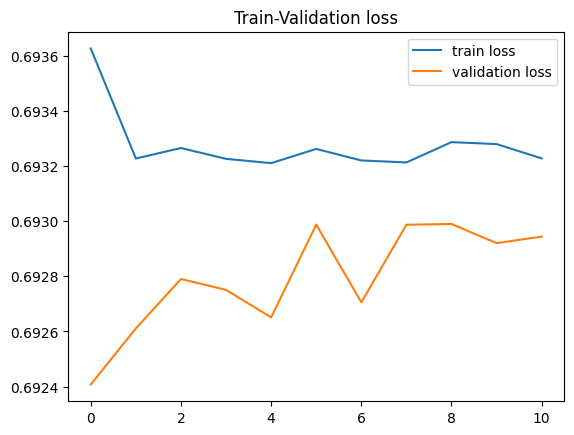

In [36]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
save_path=f'm1_rrnn_{encoding_type}_as_w2v_3'


optimizer = AdamW(model.parameters(), lr=learning_rate)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [37]:
model = rrnn.SingleTaskRRNNDep(dep_vocab = vocab_dep, vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5089285714285714, 'precision': 0.5089285714285714, 'f1': 0.5089285714285714, 'accuracy': 0.5089285714285714}
MALE {'recall': 0.0026041666666666665, 'precision': 0.0026041666666666665, 'f1': 0.0026041666666666665, 'accuracy': 0.0026041666666666665}
FEMALE {'recall': 0.995, 'precision': 0.995, 'f1': 0.995, 'accuracy': 0.995} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.004866180048661801, 'precision': 0.004866180048661801, 'f1': 0.004866180048661801, 'accuracy': 0.004866180048661801}
FEMALE {'recall': 0.994750656167979, 'precision': 0.994750656167979, 'f1': 0.994750656167979, 'accuracy': 0.994750656167979} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48239895697522817, 'precision': 0.48239895697522817, 'f1': 0.48239895697522817, 'accuracy': 0.48239895697522817}


In [38]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5025510204081632, 'precision': 0.5025510204081632, 'f1': 0.5025510204081632, 'accuracy': 0.5025510204081632}
Métricas etiqueta male: {'recall': 0.2482638888888889, 'precision': 0.2482638888888889, 'f1': 0.2482638888888889, 'accuracy': 0.2482638888888889}
Métricas etiqueta female:  {'recall': 0.7466666666666666, 'precision': 0.7466666666666666, 'f1': 0.7466666666666666, 'accuracy': 0.7466666666666666}

 to
Resultado global: {'recall': 0.4970538720538721, 'precision': 0.4970538720538721, 'f1': 0.4970538720538721, 'accuracy': 0.4970538720538721}
Métricas etiqueta male: {'recall': 0.25385239253852393, 'precision': 0.25385239253852393, 'f1': 0.25385239253852393, 'accuracy': 0.25385239253852393}
Métricas etiqueta female:  {'recall': 0.7594050743657043, 'precision': 0.7594050743657043, 'f1': 0.7594050743657043, 'accuracy': 0.7594050743657043}

 as
Resultado global: {'recall': 0.4906562364189483, 'precision': 0.4906562364189483, 'f1':